## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

# Multiprocessing
import multiprocessing
from joblib import parallel_backend, Parallel, delayed
from dask.distributed import Client
num_cores = multiprocessing.cpu_count()
client = Client()
# Multiprocessing

import glob
import gc
from sklearn.model_selection import train_test_split

import random
import utilities as util
import augmentations as aug

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-9j_l8_sg', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:42039
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34355'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40931'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:42393', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:42393
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:48318
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:37931', name: 1, status: init, memory: 0, proc

## Download files

UNET Model Creation

In [2]:
input_shape = (512, 640, 1)
output_channels = 1
sigma_noise = 0
channels_list = [128 , 64 , 32 , 32]

kernel_initializer='glorot_uniform'
#kernel_initializer='he_normal'

def unet():
    unet_input = tf.keras.layers.Input(shape=input_shape)

    list_features = []
    x = unet_input
    for i, n_channels in enumerate(channels_list):
        x = tf.keras.layers.Conv2D(n_channels, 3, activation='relu', kernel_initializer=kernel_initializer, padding='same', name=f'Encoder_conv_{i}')(x)
        #print(f'encoder layer number {i} number of channel {n_channels}')
        list_features.append((n_channels, x))
        x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)


    for i, (n_channels, same_reso_features) in enumerate(reversed(list_features)):
        #print(f'decoder layer number {i} number of channel {n_channels}')
        #print(f'concat decoder layer number {i} number of channel {same_reso_features}')
        x = tf.keras.layers.UpSampling2D(2)(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, same_reso_features])
        x = tf.keras.layers.Conv2D(n_channels, 3, activation='elu', padding='same', kernel_initializer=kernel_initializer, name=f'Decoder_conv_{i}')(x)

    if sigma_noise > 0:
            x = tf.keras.layers.GaussianNoise(sigma_noise)(x)

    unet_output = tf.keras.layers.Conv2D(output_channels, 3, activation='sigmoid', padding='same')(x)

    model = tf.keras.Model(unet_input, unet_output, name='unet')

    return model

In [4]:
gc.collect()

104

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

model = unet()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Preprocessing

### Data Augmentation

### DATA loading

In [ ]:
def rebin(img):

  new_shape = (int(img.shape[0]/2), int(img.shape[1]/2))

  shape = (new_shape[0], img.shape[0] // new_shape[0],
  new_shape[1], img.shape[1] // new_shape[1])
  return img.reshape(shape).mean(-1).mean(1)

In [5]:
DR = 2**14
def open_fits_with_mask(filename):
    image = fits.open(filename)
    cloud = image[0].data
    mask = image[1].data

    del image

    cloud  = cloud / DR
    return cloud , mask

In [6]:
images_list = glob.glob('/content/MASKED_IMAGES/*.fits')
images_list = images_list[:400]

In [7]:
len(images_list)

400

In [8]:
import random
images_list = random.choices(images_list, k=len(images_list))

In [9]:
with parallel_backend('threading', n_jobs=num_cores):
    l_fits = Parallel(verbose=0)(delayed(open_fits_with_mask)(filename=r) for r in images_list)
l_fits = np.array(l_fits)

In [10]:
k = round(len(l_fits) * 0.20)
l_fits_to_augment = random.choices(l_fits, k=k)

with parallel_backend('threading', n_jobs=num_cores):
    aug_fits = Parallel(verbose=0)(delayed(aug.random_augment)(img_mask=l_fit) for l_fit in l_fits_to_augment)
aug_fits = np.array(aug_fits)

In [17]:
l_fits.shape

(783, 2, 512, 640)

In [18]:
aug_fits.shape

(392, 2, 512, 640)

In [12]:
l_fit_stack = np.concatenate((l_fits, aug_fits), axis=0)

In [16]:
l_fit_stack.shape

(480, 2, 512, 640)

In [23]:
gc.collect()

34878

In [15]:
del aug_fits , l_fits

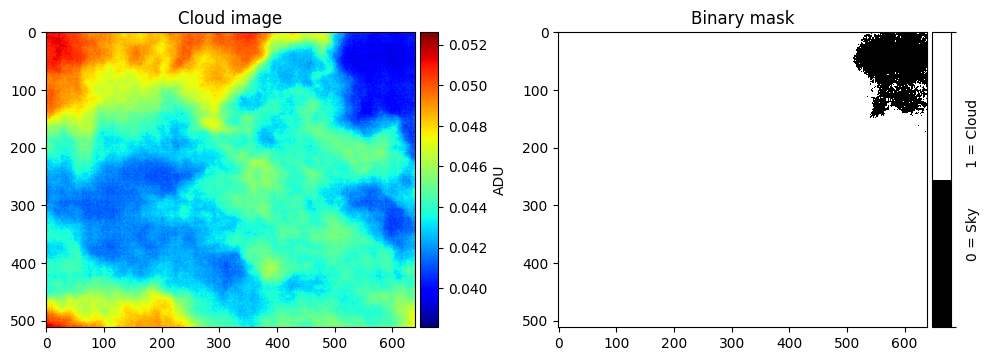

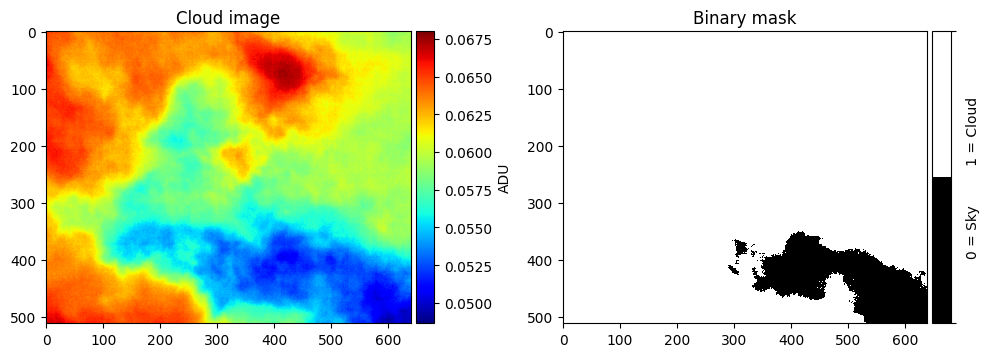

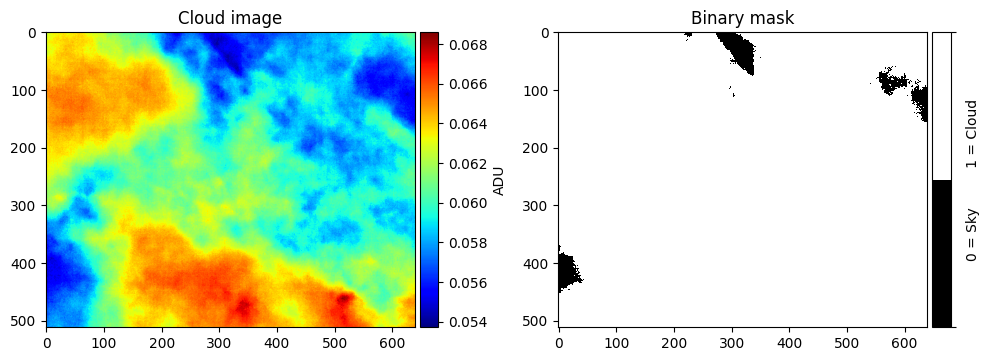

In [17]:
random_index = random.randint(0, len(l_fit_stack) - 1)
util.plot_image(data=l_fit_stack[random_index])
random_index = random.randint(0, len(l_fit_stack) - 1)
util.plot_image(data=l_fit_stack[random_index])
random_index = random.randint(0, len(l_fit_stack) - 1)
util.plot_image(data=l_fit_stack[random_index])

## DataSet gen and batching

In [21]:
class CloudImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x_data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indices[start_idx:end_idx]

        batch_x = self.x_data[batch_indices]
        batch_y = self.y_data[batch_indices]

        # You can perform any preprocessing here before returning the batch

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [18]:
images_cloud = l_fit_stack[:,0]
mask_cloud = l_fit_stack[:,1]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(images_cloud, mask_cloud, test_size=0.2, random_state=42)

In [22]:
ds_train_gen = CloudImageDataGenerator(x_data=X_train,y_data=y_train,batch_size=8, shuffle=True)
ds_val_gen = CloudImageDataGenerator(x_data=X_test,y_data=y_test,batch_size=8, shuffle=True)

## Training

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.01, mode='auto', baseline=None, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 10) , verbose=1)

history = model.fit(ds_train_gen,validation_data=ds_val_gen, epochs=100, callbacks=[lr_schedule, early_stopping])
#history = model.fit(images_cloud, mask_cloud, validation_split=0.2, epochs=50, batch_size = 16 , callbacks=[lr_schedule, early_stopping])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
48/48 [==============================] - 106s 1s/step - loss: 0.4284 - accuracy: 0.8451 - val_loss: 0.3829 - val_accuracy: 0.8598 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
48/48 [==============================] - 63s 1s/step - loss: 0.4080 - accuracy: 0.8451 - val_loss: 0.3779 - val_accuracy: 0.8598 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
48/48 [==============================] - 63s 1s/step - loss: 0.3937 - accuracy: 0.8451 - val_loss: 0.3851 - val_accuracy: 0.8598 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
48/48 [==============================] - 63s 1s/step - loss: 0.3941 - accuracy: 0.8451 - val_loss: 0.4010 - val_accuracy: 0.8598 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
48/48 [==============================] - 62s 1s/ste

In [ ]:
# Plotting
plt.figure(figsize=(12, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Assuming 'model' is your Keras model
model.save('full_model.h5')

## Plot result

In [ ]:
batch_size = 5  # Set the batch size that works for your memory capacity

# Calculate the number of batches
num_batches = len(X_test) // batch_size

# Initialize an empty list to store predictions
all_predictions = []

# Predict using batches
for batch_index in range(num_batches):
    start_index = batch_index * batch_size
    end_index = (batch_index + 1) * batch_size

    batch_X = X_test[start_index:end_index]
    batch_predictions = model.predict(batch_X)
    print(batch_predictions.shape)
    all_predictions.append(batch_predictions)

# If there are any remaining samples not covered by full batches
if len(X_test) % batch_size != 0:
    last_batch_X = X_test[num_batches * batch_size:]
    last_batch_predictions = model.predict(last_batch_X)

    all_predictions.append(last_batch_predictions)

# Combine predictions from all batches
predictions = np.vstack(all_predictions)  # Assuming numpy is imported

In [ ]:
all_predictions[0].shape

In [ ]:
batch_predictions = model.predict(X_test)

In [ ]:
y_predictions = np.squeeze(predictions, axis=-1)

In [ ]:
y_predictions.shape

In [ ]:
random_index = random.randint(0, len(X_test) - 1)
plot_image_pred(X_test[random_index], y_test[random_index], y_predictions[random_index])

In [ ]:
y_test[1]

In [ ]:
# Create a random NumPy array for demonstration
i = 25
thresh = 0.8
origin = y_predictions[i]
origin_gt = y_test[i]
image_array = np.array(y_predictions[i])

image_array[image_array >= thresh] = 1
image_array[image_array < thresh] = 0

# Plot the NumPy array as an image
plt.imshow(origin_gt, cmap='gray')  # 'gray' colormap for grayscale images
plt.title('Image Plot')
plt.colorbar()  # Display colorbar
plt.show()
# Plot the NumPy array as an image
plt.imshow(origin, cmap='gray')  # 'gray' colormap for grayscale images
plt.title('Image Plot')
plt.colorbar()  # Display colorbar
plt.show()
# Plot the NumPy array as an image
plt.imshow(image_array, cmap='gray')  # 'gray' colormap for grayscale images
plt.title('Image Plot')
plt.colorbar()  # Display colorbar
plt.show()

In [ ]:
y_test[29]

In [ ]:
y_predictions[29]